In [1]:
!pip install pyspark --quiet

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [19]:

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("NYCTaxiAnalysis") \
    .getOrCreate()
df = spark.read.parquet("/content/yellow_tripdata_2025-01.parquet")

df.printSchema()
df.show(5)


root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------

In [20]:
print(f"Total Records: {df.count():,}")

Total Records: 3,475,226


In [21]:
sample_df = df.sample(fraction=0.01, seed=42)
sample_df.printSchema()
sample_df.show(5)

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------

#Data Cleaning

In [22]:
from pyspark.sql.functions import col, when, count

# Check null percentages
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show(vertical=True)

# Drop rows with missing vals
clean_df = df.na.drop(subset=[
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "PULocationID",
    "DOLocationID",
    "passenger_count",
    "trip_distance",
    "total_amount"
])

-RECORD 0-----------------------
 VendorID              | 0      
 tpep_pickup_datetime  | 0      
 tpep_dropoff_datetime | 0      
 passenger_count       | 540149 
 trip_distance         | 0      
 RatecodeID            | 540149 
 store_and_fwd_flag    | 540149 
 PULocationID          | 0      
 DOLocationID          | 0      
 payment_type          | 0      
 fare_amount           | 0      
 extra                 | 0      
 mta_tax               | 0      
 tip_amount            | 0      
 tolls_amount          | 0      
 improvement_surcharge | 0      
 total_amount          | 0      
 congestion_surcharge  | 540149 
 Airport_fee           | 540149 



In [23]:
# Define reasonable ranges
clean_df = clean_df.filter( (col("passenger_count") > 0) &
    (col("passenger_count") <= 6) &
    (col("trip_distance") > 0) &
    (col("trip_distance") <= 100) &  # 100 miles max
    (col("total_amount") > 0) &
    (col("total_amount") <= 500) &   # $500 max fare
    (col("fare_amount") > 0))


In [24]:
from pyspark.sql.functions import datediff

clean_df = clean_df.filter(
    datediff(col("tpep_dropoff_datetime"), col("tpep_pickup_datetime")) >= 0
)

#PeakHourAnalysis

In [25]:
from pyspark.sql.functions import hour, dayofweek, month

time_df = clean_df.withColumn("pickup_hour", hour("tpep_pickup_datetime")) \
                 .withColumn("pickup_day", dayofweek("tpep_pickup_datetime")) \
                 .withColumn("pickup_month", month("tpep_pickup_datetime"))

In [26]:
from pyspark.sql.functions import count, avg

hourly_stats = time_df.groupBy("pickup_hour") \
                     .agg(
                         count("*").alias("trip_count"),
                         avg("total_amount").alias("avg_fare"),
                         avg("trip_distance").alias("avg_distance")
                     ) \
                     .orderBy("pickup_hour")

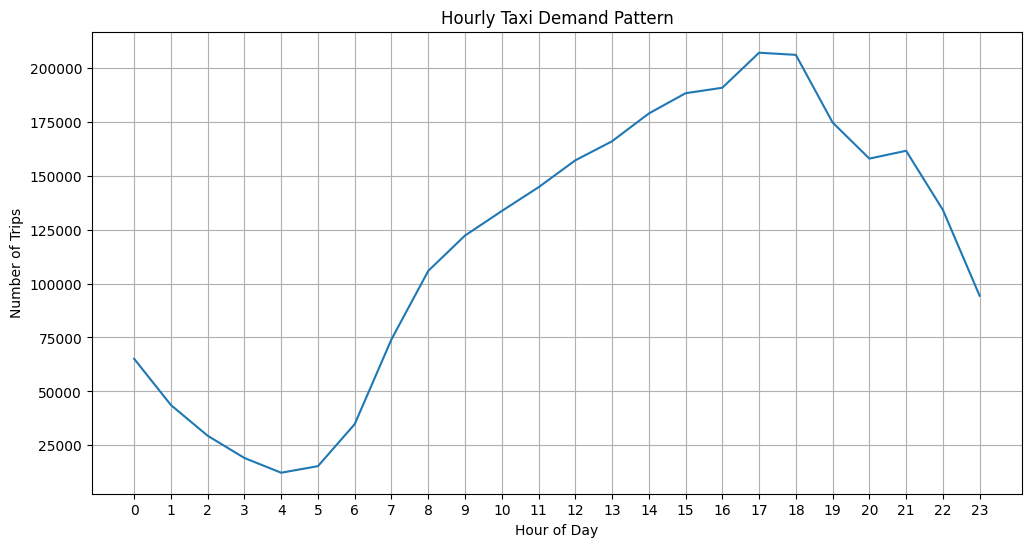

In [18]:

# Convert to Pandas
hourly_pd = hourly_stats.toPandas()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_pd, x="pickup_hour", y="trip_count")
plt.title("Hourly Taxi Demand Pattern")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.xticks(range(0, 24))
plt.grid()
plt.show()

In [27]:
day_stats = time_df.groupBy("pickup_day") \
                  .agg(count("*").alias("trip_count")) \
                  .orderBy("pickup_day")

# Convert day numbers to names
day_map = {1: "Sunday", 2: "Monday", 3: "Tuesday",
           4: "Wednesday", 5: "Thursday", 6: "Friday", 7: "Saturday"}

#Route Analysis

In [30]:
zones = spark.read.csv("taxi_zone_lookup.csv", header=True)

# Join with main data
route_df = clean_df.join(zones.alias("pickup_zones"),
                        col("PULocationID") == col("pickup_zones.LocationID")) \
                   .join(zones.alias("dropoff_zones"),
                        col("DOLocationID") == col("dropoff_zones.LocationID"))

In [48]:
top_routes = route_df.groupBy(
    "pickup_zones.Zone", "dropoff_zones.Zone"
).count().orderBy("count", ascending=False).limit(10)
top_routes.show(5)

+--------------------+--------------------+-----+
|                Zone|                Zone|count|
+--------------------+--------------------+-----+
|Upper East Side S...|Upper East Side N...|23456|
|Upper East Side N...|Upper East Side S...|20262|
|Upper East Side N...|Upper East Side N...|16401|
|Upper East Side S...|Upper East Side S...|15631|
|      Midtown Center|Upper East Side S...|10711|
+--------------------+--------------------+-----+
only showing top 5 rows



In [32]:
from pyspark.sql.functions import unix_timestamp

route_duration = route_df.withColumn(
    "trip_duration_minutes",
    (unix_timestamp("tpep_dropoff_datetime") -
     unix_timestamp("tpep_pickup_datetime")) / 60
).filter(col("trip_duration_minutes") > 0)

avg_duration = route_duration.groupBy(
    "pickup_zones.Zone", "dropoff_zones.Zone"
).agg(
    avg("trip_duration_minutes").alias("avg_duration"),
    count("*").alias("trip_count")
).filter(col("trip_count") > 100).orderBy("avg_duration", ascending=False)

In [37]:
from pyspark.sql.functions import when, dayofweek, hour

model_df = clean_df.withColumn(
    "is_weekend",
    when((dayofweek("tpep_pickup_datetime") == 1) |
         (dayofweek("tpep_pickup_datetime") == 7), 1).otherwise(0)
).withColumn(
    "is_rush_hour",
    when(
        ((hour("tpep_pickup_datetime") >= 7) &
         (hour("tpep_pickup_datetime") <= 10)) |
        ((hour("tpep_pickup_datetime") >= 16) &
         (hour("tpep_pickup_datetime") <= 19)), 1
    ).otherwise(0)
)


In [38]:
train, test = model_df.randomSplit([0.8, 0.2], seed=42)

In [39]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor

# Feature columns
feature_cols = [
    "trip_distance",
    "passenger_count",
    "PULocationID",
    "DOLocationID",
    "is_weekend",
    "is_rush_hour"
]

# Pipeline stages
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
rf = RandomForestRegressor(featuresCol="features", labelCol="total_amount")

pipeline = Pipeline(stages=[assembler, rf])
model = pipeline.fit(train)

In [40]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = model.transform(test)

evaluator = RegressionEvaluator(
    labelCol="total_amount",
    predictionCol="prediction",
    metricName="rmse"
)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 8.699439526545813


In [43]:
rf_model = model.stages[-1]
importances = rf_model.featureImportances.toArray()

feature_importance = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values("importance", ascending=False)

In [44]:
model.save("nyc_taxi_fare_model")